In [199]:
import pandas as pd

ds = pd.read_csv('./labelling/data_cleaned_manual.csv')

questions = list(ds['Question'])

ds.head()


,Question,Global Subject,Question Intent,Multiple Subjects
0,Hi,start,greet,False
1,Describe the automaton,automaton,description,False
2,Is there a transition between q2 and q0?,transition,existence_between,False
3,Is there a transition between q5 and q7,transition,existence_between,False
4,"Please, describe the automaton",automaton,description,False


In [200]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(questions)

embeddings.shape

(229, 384)

In [201]:
technique = 'AC'

if technique == 'AC':
    from sklearn.cluster import AgglomerativeClustering
    
    distance_threshold = 0.9
    
    # The linkage parameter determines how the clustering merges are performed:
    # 
    # 'ward': Minimizes the variance of the clusters being merged. Commonly used 
    # 'complete': Maximizes the distance between the farthest points of clusters.
    # 'average': Uses the average distance of each cluster to every point of the other cluster.
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, linkage='complete')
    clustering_model.fit(embeddings)
    
    cluster_assignments = clustering_model.labels_

    num_clusters = clustering_model.n_clusters_

    clustered_questions = [[] for _ in range(num_clusters)]
    for question, label in zip(questions, cluster_assignments):
        clustered_questions[label].append(question)
    
    # Display the clusters
    for idx, cluster in enumerate(clustered_questions):
        print(f"Cluster {idx + 1}:")
        for q in cluster:
            print(f" - {q}")
        print("\n")

else:
    from sklearn.cluster import KMeans

    # Decide on the number of clusters, e.g., 5
    num_clusters = 8
    
    # Initialize and fit KMeans
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    
    # Get cluster assignments
    cluster_assignments = clustering_model.labels_

    clustered_questions = [[] for _ in range(num_clusters)]
    for idx, label in enumerate(cluster_assignments):
        clustered_questions[label].append(questions[idx])

    for i, cluster in enumerate(clustered_questions):
        print(f"Cluster {i+1}:")
    for question in cluster:
        print(f" - {question}")
    print("\n")


Cluster 1:
 - What grammar does the automaton recognise?
 - What are the input symbols that the automaton accepts?
 - What is the language recognised by the automaton?
 - What is the language accepted by the automaton?
 - What symbols does the automaton accept?
 - What are the symbols accepted by the automaton?
 - What is the grammar recognised by the automaton?
 - What is the regular expression describing the automata?
 - What is the regular expression that corresponds to the automaton?
 - What language does the automaton accept?


Cluster 2:
 - Can you describe the automata?
 - What can I use a finite state automata for?
 - What language does this automata accept?
 - Can you briefly describe the automata?


Cluster 3:
 - Is there an arc from q0 to q1?
 - Is there an arc from q0 to q2, q3 or q4?
 - Is there an arc from q1 to q2?
 - Is there an arc from q2 to q3?
 - Is there an arc from q3 to q4?
 - Is there an arc from q4 to q0?
 - Is there an arc from q4?
 - Is there an arc from q0?


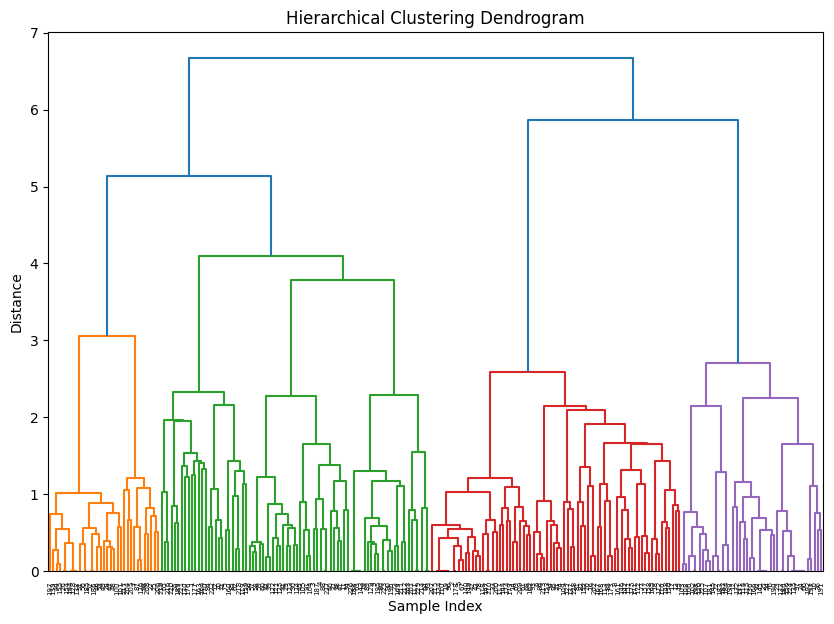

In [202]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform linkage for the dendrogram
linked = linkage(embeddings, 'ward')

# Plot the dendrogram
labelList = range(1, len(questions) + 1)
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=labelList)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


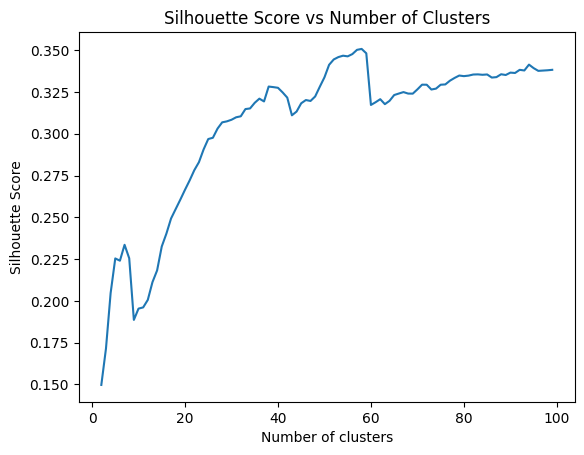

In [203]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score for different numbers of clusters
import numpy as np

range_n_clusters = list(range(2, 100))
silhouette_scores = []

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = clustering.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()


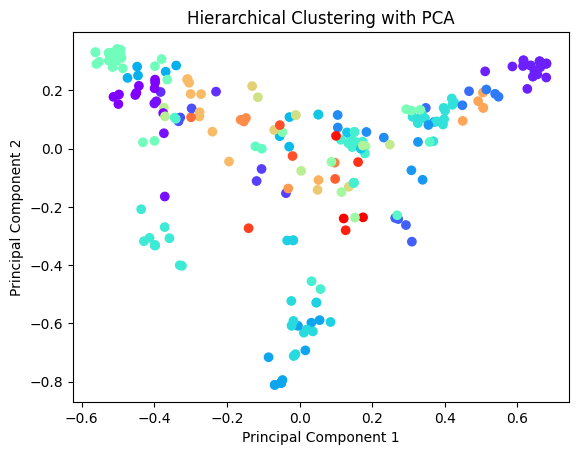

In [204]:
from sklearn.decomposition import PCA

# Reduce embeddings to 2D
pca = PCA(n_components=5)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_assignments, cmap='rainbow')
plt.title('Hierarchical Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


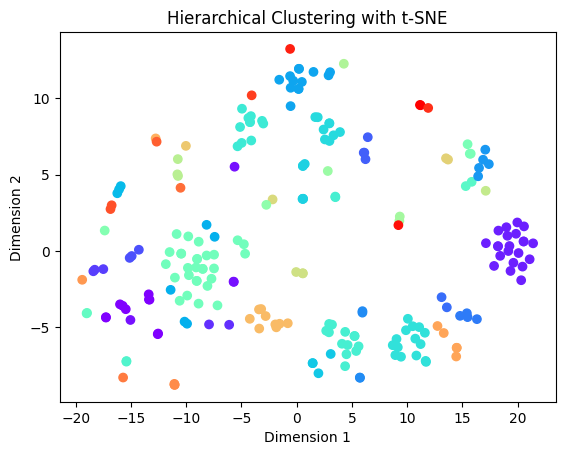

In [205]:
from sklearn.manifold import TSNE

# Reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_assignments, cmap='rainbow')
plt.title('Hierarchical Clustering with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


# Higher dimension analysis

In [209]:
# Initialize t-SNE with desired parameters
tsne = TSNE(
    n_components=2,      # We want to reduce to 2 dimensions for visualization
    perplexity=30,       # Adjust as needed
    learning_rate=200,   # Default learning rate
    n_iter=1000,         # Number of iterations
    random_state=42      # For reproducibility
)

# Fit and transform the data
embeddings_tsne = tsne.fit_transform(reduced_embeddings)  # Use embeddings directly if skipping PCA

# Create a DataFrame for easy plotting
tsne_df = pd.DataFrame({
    'Dim1': embeddings_tsne[:, 0],
    'Dim2': embeddings_tsne[:, 1],
    # 'Label': your_labels  # If you have labels to color-code
})

# Assuming you have a list or array called 'labels' corresponding to each embedding
tsne_df['Label'] = ds['Global Subject']  # Replace with your actual labels

# Plot with color-coding
plt.figure(figsize=(8, 6))
for label in tsne_df['Label'].unique():
    indices = tsne_df['Label'] == label
    plt.scatter(tsne_df.loc[indices, 'Dim1'], tsne_df.loc[indices, 'Dim2'], label=label, s=50, alpha=0.7)

plt.legend()
plt.title('t-SNE Visualization with Labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()



/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ValueError: n_components=3 must be between 1 and min(n_samples, n_features)=2 with svd_solver='randomized'